In [ ]:
import torch
import torch.nn as nn # модуль, где определены слои для нейронных сетей
from torchvision import datasets, transforms, io, models
import torch.utils.data as data #для split-а
import torch.nn.functional as F # модуль, где определены активайии для слоев нейронных сетей

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from google.colab import files

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
%matplotlib inline

from tqdm.notebook import tqdm
import numpy as np
import os
import gc
from glob import glob

# загрузка данных

https://www.kaggle.com/andrewmvd/animal-faces

### предподготовка к загрузке датасетов

In [ ]:
# загрузка kaggle API в файле "kaggle.json"
files.upload()

# проверка актуальности загруженного API
!ls -lha kaggle.json

# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 65 May 11 14:53 kaggle.json


In [ ]:
# поиск необходимого датасета
!kaggle datasets list -s animal

# загрузка датасета
!kaggle datasets download -d andrewmvd/animal-faces

# разархивирование
!unzip animal-faces.zip

# список файлов в директории
!ls

In [ ]:
# список файлов в директории afhq/train
!ls afhq/train

cat  dog  wild


### загрузка датасетов

### проверка вариативности размерности картинок

In [ ]:
img_size_list = []
for i in tqdm(glob('afhq/train/cat/*')):
  tsr_img = io.read_image('afhq/train/cat/pixabay_cat_002895.jpg')
  img_size_list.append(tsr_img.shape)

for i in tqdm(glob('afhq/train/dog/*')):
  tsr_img = io.read_image('afhq/train/cat/pixabay_cat_002895.jpg')
  img_size_list.append(tsr_img.shape)

for i in tqdm(glob('afhq/train/wild/*')):
  tsr_img = io.read_image('afhq/train/cat/pixabay_cat_002895.jpg')
  img_size_list.append(tsr_img.shape)

set(img_size_list)

  0%|          | 0/5153 [00:00<?, ?it/s]

  0%|          | 0/4739 [00:00<?, ?it/s]

  0%|          | 0/4738 [00:00<?, ?it/s]

{torch.Size([3, 512, 512])}

### директории датасета

https://blog.jovian.ai/apply-deep-neural-network-on-the-animal-faces-dataset-f573cb732e63

In [ ]:
data_dir = 'afhq/'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print('3 classes :', classes)

Folders : ['train', 'val']
3 classes : ['wild', 'dog', 'cat']


### train-dataset

In [ ]:
# можно из коробки приводить все изображения к единому формату, конвертировать в торч тензор и нормализовывать
data_transform = transforms.Compose([
         #transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(data_dir + '/train', transform=data_transform) #transform=transforms.ToTensor()
print('Size of training Dataset :', len(dataset))

val_ds = datasets.ImageFolder(data_dir + '/val', transform=data_transform)
print('Size of val Dataset :', len(val_ds))

Size of training Dataset : 14630
Size of val Dataset : 1500


### image shape

In [ ]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 512, 512])


### отрисовка изображения

Label:  cat (0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


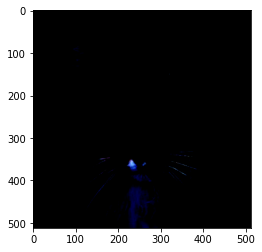

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    
show_example(*dataset[0])

# for i in range(3):
#   show_example(*dataset[i])

# выделение тестовой выборки

In [ ]:
torch.manual_seed(43)
test_size = 5000
train_size = len(dataset) - test_size

train_ds, test = data.random_split(dataset, [train_size, test_size])
len(train_ds), len(test)

(9630, 5000)

### создание выборок для обучения: dataset -> variable

In [ ]:
batch_size = 15
# загрузчики треин и тест части
train_loader = data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(val_ds, batch_size, num_workers=2)
test_loader = data.DataLoader(test, batch_size, num_workers=2)

# нейронка

### функция обучения сети

In [ ]:
device = torch.device('cuda')
print( torch.cuda.is_available() )
print( torch.cuda.get_device_name() )

In [ ]:
def train(net, n_epoch=1):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # обнуляем градиент
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bаckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()
            
            # проверяем качество каждые 100 батчей
            if i % 200 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
input_size = 3*512*512 # INPUT SIZE
output_size = 3 # Number of classes

###  попытка №1 (SimpleNet)

In [ ]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(input_size, 256) # полносвязные слои - вход и выход
        self.fc2 = nn.Linear(256, output_size)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [ ]:
# объявляем сеть
net = SimpleNet().to(device)
# теперь обучить сеть можно вызвав функцию train и передав туда переменную сети.
net = train(net)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

New best model with test acc: 0.33333333333333326
[1,   100] loss: 0.247
[1,   200] loss: 0.242
[1,   300] loss: 0.243
[1,   400] loss: 0.249
[1,   500] loss: 0.251
[1,   600] loss: 0.247
Обучение закончено


In [ ]:
# Посчитаем accuracy на test:
with torch.no_grad():
    accuracy = []
    for batch in val_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = net(x)
        accuracy.append(accuracy_score(y.cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('accuracy', accuracy)

accuracy 0.33073852295409184


### попытка №2 (ConvNet)

In [ ]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = nn.Conv2d(20, 3, kernel_size=3) 
        self.flatten = Flatten()
        self.fc = nn.Linear(774192, output_size) # какой тут будет размер входа? не всегда очевидно, особенно когда слоев много и этапов много, пробуйте выводить x.size() при прямом проходе
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        # print(x.size())
        x = F.relu(self.conv1(x))
        # print(x.size())
        x = F.relu(self.conv2(x))
        # print(x.size())
        x = self.flatten(x)
        # print(x.size())
        # умножение на матрицу весов 2 слоя и применение функции активации
        # print(x.size())
        x = F.softmax(self.fc(x), dim=1)
        # print(x.shape)
        return x

In [ ]:
# объявляем сеть
net = ConvNet().cuda()
# обучаем
net = train(net)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

New best model with test acc: 0.41800000000000004
[1,   100] loss: 0.244
[1,   200] loss: 0.245
[1,   300] loss: 0.246
[1,   400] loss: 0.245
[1,   500] loss: 0.249
[1,   600] loss: 0.248
Обучение закончено


In [ ]:
# проверяем по метрикам
with torch.no_grad():
    accuracy = []
    for batch in val_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

Test accuracy 0.33073852295409184


### попытка №3 (CNN + Pool + skip-connection + adding_end)

In [ ]:
class Conv3Pool1_Sum(nn.Module):
    """ Блок свёртки и пулинга со skip-connection и сложением на конце"""
    def __init__(self, in_c, out_c, kernel=3, pad=1, norm=False):
        super().__init__()
        self.conv1 = nn.Sequential(
                      nn.Conv2d( in_channels=in_c,
                                out_channels=out_c,
                                kernel_size=kernel,
                                padding=pad),    # вход 256, 256
                      nn.LeakyReLU(), 
                      )               
        self.bn1 = None
        if norm:
            self.bn1 = nn.BatchNorm2d(out_c) 
        self.conv2 = nn.Sequential(                          
                      nn.Conv2d( in_channels=out_c, out_channels=out_c, kernel_size=kernel, padding=pad),    
                      nn.LeakyReLU(), 
                      # nn.BatchNorm2d(out_c)
                      )         
        self.conv3 = nn.Sequential(                          
                      nn.Conv2d( in_channels=out_c, out_channels=out_c, kernel_size=kernel, padding=pad),    
                      nn.LeakyReLU(), 
                      # nn.BatchNorm2d(out_c)
                      )         
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.init_weights()


    def init_weights(self):
        for l in [self.conv1, self.conv2, self.conv3]:
            # He инициализация весов из нормального распределения
            # по-умолчанию используется Xavier инициализация
            torch.nn.init.kaiming_normal_(l[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')  # a -- коэффициент определяющий наклон левой части ReLU

    def forward(self, x):
        x1 = self.conv1(x)
        if self.bn1:
            x1 = self.bn1(x1)
        x  = self.conv2(x1)
        x2 = self.conv3(x)
        x = x1 + x2
        x = self.pool1(x)
        return x

class CNN(nn.Module):
    """Сеть с skip-connection и конкатенацией внутри отдельных блоков"""
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = Conv3Pool1_Sum(3,   32)                                             # 128
        self.conv2 = Conv3Pool1_Sum(32,  64)                                             # 64
        self.conv3 = Conv3Pool1_Sum(64,  128)                                            # 32
        self.conv4 = Conv3Pool1_Sum(128, 128, norm=True)                                 # 16

        self.fc1 = nn.Sequential(            
                      nn.Linear(in_features=131072, out_features=256, ),
                      nn.Dropout(0.2),
                      nn.LeakyReLU())
        # self.fc2 = nn.Sequential(            
        #               nn.Linear(in_features=512, out_features=64),
        #               nn.LeakyReLU())
        self.fc2_bn =  nn.BatchNorm1d(256)
        self.out = nn.Sequential(            
                      nn.Linear(in_features=256, out_features=n_classes),
                      # nn.SoftMax()
                                          )
        self.init_weights()
                          
    
    def init_weights(self):
        for l in [self.fc1, self.out]:
            # He инициализация весов из нормального распределения
            # по-умолчанию используется Xavier инициализация
            torch.nn.init.kaiming_normal_(l[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')  # a -- коэффициент определяющий наклон левой части ReLU

    def forward(self, x):
        # x = x.view(x.shape[0], 1, 256, 256 )
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1)
        # print(x.size())
        x = self.fc1(x)
        # x = self.fc2(x)
        # if self.training: 
        x = self.fc2_bn(x)   # иначе бачнорм на одном объекте упадёт на инференсе
        x = self.out(x)
        return x

In [ ]:
torch.cuda.empty_cache()
gc.collect()

147

In [ ]:
# тут 3 - кол-во классов
cnn = CNN(3).to(device)
# обучаем
net = train(cnn, n_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

New best model with test acc: 0.3366666666666667
[1,   100] loss: 0.213
[1,   200] loss: 0.110
New best model with test acc: 0.34666666666666673
[1,   300] loss: 0.097
[1,   400] loss: 0.083
New best model with test acc: 0.3726666666666667
[1,   500] loss: 0.069
[1,   600] loss: 0.073
New best model with test acc: 0.38
[1,   700] loss: 0.076
[1,   800] loss: 0.050
[1,   900] loss: 0.054
Обучение закончено


In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in val_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

Test accuracy 0.37933333333333336


### попытка №4 (augmentetion)


https://medium.com/analytics-vidhya/transforming-data-in-pytorch-741fab9e008c


In [ ]:
augmentation_transform = transforms.Compose([
        #  transforms.RandAugment(num_ops=10, interpolation = 3),
         transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])

dataset_aug = datasets.ImageFolder(data_dir + '/train', transform=augmentation_transform) #transform=transforms.ToTensor()
print('Size of old training Dataset :', len(dataset))
print('Size of new training Dataset :', len(dataset_aug))

val_ds_aug = datasets.ImageFolder(data_dir + '/val', transform=augmentation_transform)
print('Size of old val Dataset :', len(val_ds))
print('Size of new val Dataset :', len(val_ds_aug))

Size of old training Dataset : 14630
Size of new training Dataset : 14630
Size of old val Dataset : 1500
Size of new val Dataset : 1500


In [ ]:
train_loader = data.DataLoader(dataset_aug, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(val_ds_aug, batch_size, num_workers=2)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

176

In [ ]:
# тут 3 - кол-во классов
cnn = CNN(3).to(device)
# обучаем
net = train(cnn, n_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/976 [00:00<?, ?it/s]

New best model with test acc: 0.336
[1,   100] loss: 0.259
[1,   200] loss: 0.167
[1,   300] loss: 0.124
[1,   400] loss: 0.115
New best model with test acc: 0.3400000000000001
[1,   500] loss: 0.103
[1,   600] loss: 0.091
[1,   700] loss: 0.095
[1,   800] loss: 0.086
New best model with test acc: 0.374
[1,   900] loss: 0.073
Обучение закончено


In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in val_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

Test accuracy 0.3646666666666667


### попытка №5 (файнтюнинг)

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
# нам не нужен последний слой, обрезаем его
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()))[:-1]
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
class New_VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16 # вся огромная нейросеть в одну строчку
        for param in self.vgg16.features.parameters(): # отключаем для нее обновление параметров
            param.requires_grad = False
        self.fc = nn.Linear(4096, output_size) # добавляем новый слой
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.vgg16(x)
        # print(x.size())
        x = self.fc(x)
        return x

In [ ]:
torch.cuda.empty_cache()
gc.collect()

595

In [ ]:
net = New_VGG16().to(device)
train(net)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/642 [00:00<?, ?it/s]

New best model with test acc: 0.5493333333333335
[1,   100] loss: 0.146
[1,   200] loss: 0.205
New best model with test acc: 0.964
[1,   300] loss: 0.288
[1,   400] loss: 0.326
New best model with test acc: 0.9833333333333333
[1,   500] loss: 0.546
[1,   600] loss: 0.199
New best model with test acc: 0.9926666666666667
Обучение закончено


New_VGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in val_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

Test accuracy 0.9926666666666667


# результат прогноза

In [ ]:
dataiter = iter(test_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [ ]:
# размер датасета
images.shape, labels.shape

(torch.Size([15, 3, 512, 512]), torch.Size([15]))

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.cuda()).detach().cpu().numpy())

In [ ]:
labels_true[:3]

[tensor(1),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(2),
 tensor(0),
 tensor(1),
 tensor(0)]

In [ ]:
labels_net[:3]

[array([-6.170123 ,  2.5262122, -2.4457717], dtype=float32),
 array([-3.299338 ,  3.3251522,  2.555474 ], dtype=float32),
 array([ 4.9662037, -1.9597375, -2.563896 ], dtype=float32),
 array([-7.436723,  5.594617, -2.798032], dtype=float32),
 array([ 4.2160854 ,  0.32355884, -2.0751104 ], dtype=float32),
 array([-3.0639188, -2.5923584,  6.451467 ], dtype=float32),
 array([ 1.6080981, -2.160572 ,  2.9770658], dtype=float32),
 array([ 6.453824 , -0.6690751, -3.3631759], dtype=float32),
 array([-4.9743476,  5.7096176, -1.2397022], dtype=float32),
 array([ 5.692439 , -3.2076135, -1.6291356], dtype=float32)]

In [ ]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

In [ ]:
classification_report(labels_true, np.argmax(np.array(labels_net), axis=1))

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    
show_example(*dataset[0])

In [ ]:
# посмотрим на пару из них
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

NameError: ignored